In [1]:
import json
import os
import pandas as pd
from scipy import stats

In [2]:
nodes = ["count1", "count2", "gccount1", "gccount2", "atcount1", "atcount2", "gcsum", "atsum", "gcratio"]

base_dir = "/home/ubuntu/projects/causality-fbp/scipipe-demo/"

# concatenator breaks the audit log: https://github.com/scipipe/scipipe/issues/127
# so we need to trace audit up to concatenator
# as well as each audit files leading up to concatenator
# annoying, but alas!
audit_files = ["gcratio.txt.audit.json",
               "chry.fa.gccnt1.audit.json", "chry.fa.gccnt2.audit.json",
               "chry.fa.atcnt1.audit.json", "chry.fa.atcnt2.audit.json"]

n_repeats = 20
n_records = 30


In [3]:
def normalize_df(df):
    normalized_df=(df-df.min())/(df.max()-df.min())
    # normalized_df=(df-df.mean())/df.std()
    return normalized_df

def load_dataset(mode, repeat_id):
    if mode not in ['normal', 'break-count1', 'break-count2']:
        raise ValueError(f'Wrong mode {mode} given')
    
    if repeat_id < 1 or repeat_id > n_repeats:
        raise ValueError(f'Wrong repeat id {repeat_id} given')

    experiment_dir = os.path.join(base_dir, 'experiment', mode, f'repeat_{repeat_id}')    
    all_records = []

    for i in range(1, n_records+1):
        raw_data = {}
        for final_audit_file in audit_files:
            with open(os.path.join(experiment_dir, str(i), final_audit_file)) as f:
                audit_data = json.load(f)
            
            audit_data_queue = [audit_data]
            while audit_data_queue:
                audit_data = audit_data_queue.pop(0)
                if audit_data["ProcessName"] in nodes:
                    # we assume all our nodes output exactly one file
                    # Big Assumption!
                    data_file_name = next(iter(audit_data["OutFiles"].values()))
                    with open(os.path.join(experiment_dir, str(i), data_file_name)) as data_file:
                        line = data_file.readline()

                    # calc may output tilde for division
                    # so we need to remove it, plus any whitespaces
                    value = float(line.strip().strip('~'))
                    raw_data[audit_data["ProcessName"]] = value
                
                for upstream_data in audit_data["Upstream"].values():
                    if upstream_data:
                        audit_data_queue.append(upstream_data)
        
        all_records.append(raw_data)

    return pd.DataFrame(all_records)


In [4]:
import networkx as nx, numpy as np, pandas as pd
from dowhy import gcm

In [5]:
causal_graph = nx.DiGraph([
    ('count1', 'gccount1'),
    ('count1', 'atcount1'),
    ('count2', 'gccount2'),
    ('count2', 'atcount2'),

    ('gccount1', 'gcsum'),
    ('atcount1', 'atsum'),
    ('gccount2', 'gcsum'),
    ('atcount2', 'atsum'),

    ('gcsum', 'gcratio'),
    ('atsum', 'gcratio'),
])

In [6]:
from scipy import stats

def compute_attributions(break_mode):
    attributions_per_experiment = []
    for i in range(1, n_repeats+1):
        normal_df = load_dataset('normal', i)
        break_df = load_dataset(break_mode, i)

        causal_model = gcm.ProbabilisticCausalModel(causal_graph)
        causal_model.set_causal_mechanism('count1', gcm.EmpiricalDistribution())
        causal_model.set_causal_mechanism('count2', gcm.EmpiricalDistribution())
        causal_model.set_causal_mechanism('gccount1', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
        causal_model.set_causal_mechanism('gccount2', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
        causal_model.set_causal_mechanism('atcount1', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
        causal_model.set_causal_mechanism('atcount2', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
        causal_model.set_causal_mechanism('gcsum', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
        causal_model.set_causal_mechanism('atsum', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
        causal_model.set_causal_mechanism('gcratio', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))

        attributions = gcm.distribution_change(causal_model, normal_df, break_df, 'gcratio')
        attributions_per_experiment.append(attributions)
    
    return pd.DataFrame(attributions_per_experiment)

In [7]:
break_count1_attr_df = compute_attributions('break-count1')

/home/ubuntu/projects/causality-fbp/.venv/lib/python3.10/site-packages/dowhy/gcm/distribution_change.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_data = old_data.append(new_data, ignore_index=True, sort=True)
Estimating Shapley Values. Average change of Shapley values in run 4 (20 evaluated permutations): -16.106301796696737%: 100%|██████████| 1/1 [00:04<00:00,  4.17s/it]
/home/ubuntu/projects/causality-fbp/.venv/lib/python3.10/site-packages/dowhy/gcm/distribution_change.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_data = old_data.append(new_data, ignore_index=True, sort=True)
Estimating Shapley Values. Average change of Shapley values in run 10 (50 evaluated permutations): -6.022467345840235%: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it]
/home/ubuntu/projects/causality-fbp/.venv/

In [9]:
for column in nodes:
    if column == "count1":
        continue
    
    test_result = stats.ttest_ind(break_count1_attr_df["count1"].to_list(),
                                  break_count1_attr_df[column].to_list(),
                                  equal_var=False)
    
    print(f"{column}: p-value = {test_result.pvalue}")



count2: p-value = 6.320432565598461e-09
gccount1: p-value = 6.735446801009432e-09
gccount2: p-value = 7.45747130622992e-09
atcount1: p-value = 6.226185411695689e-09
atcount2: p-value = 6.819003747966066e-09
gcsum: p-value = 5.58748096238065e-09
atsum: p-value = 6.472158369363332e-09
gcratio: p-value = 5.283602132103391e-08


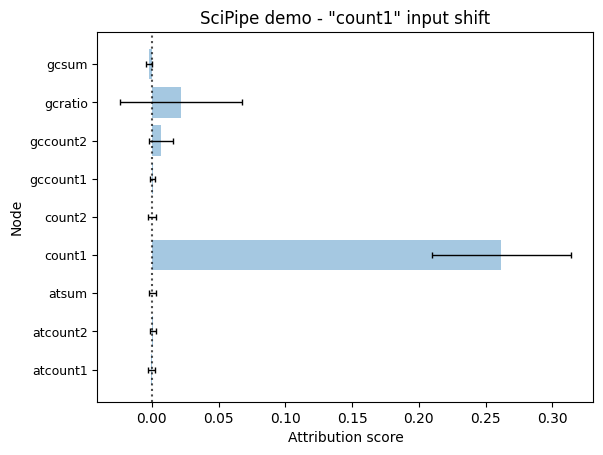

In [15]:
import math
records_count = break_count1_attr_df.shape[0]
records_means = break_count1_attr_df.mean(axis=0).to_list()
std = break_count1_attr_df.std(axis=0).to_list()
columns = break_count1_attr_df.columns.to_list()

ci95_lower = []
ci95_range = []
for m, s in zip(records_means, std):
    lower = m - 1.96*s/math.sqrt(records_count)
    ci95_lower.append(lower)
    ci95_range.append(m - lower)


import matplotlib.pyplot as plt

plt.barh(range(len(records_means)), records_means, xerr=ci95_range, alpha=0.4, align='center', error_kw={'capsize':2, 'elinewidth':1})
plt.yticks(range(len(records_means)), columns)
# plt.xscale('log')
plt.xlabel('Attribution score')
plt.ylabel('Node')
plt.yticks(fontsize=9)
# plt.xscale('symlog', base=10)
# plt.xticks([0, 0.1])
plt.axvline(0, color='black', alpha=0.7, linestyle='dotted')
plt.title('SciPipe demo - "count1" input shift')

plt.savefig("scipipe-count1.pdf", bbox_inches='tight')
plt.show()

In [11]:
break_count2_attr_df = compute_attributions('break-count2')

/home/ubuntu/projects/causality-fbp/.venv/lib/python3.10/site-packages/dowhy/gcm/distribution_change.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_data = old_data.append(new_data, ignore_index=True, sort=True)
Estimating Shapley Values. Average change of Shapley values in run 7 (35 evaluated permutations): -128.63733650858197%: 100%|██████████| 1/1 [00:01<00:00,  1.53s/it]
/home/ubuntu/projects/causality-fbp/.venv/lib/python3.10/site-packages/dowhy/gcm/distribution_change.py:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_data = old_data.append(new_data, ignore_index=True, sort=True)
Estimating Shapley Values. Average change of Shapley values in run 10 (50 evaluated permutations): 0.6371132297899946%: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it]
/home/ubuntu/projects/causality-fbp/.venv/

In [13]:
for column in nodes:
    if column == "count2":
        continue
    
    test_result = stats.ttest_ind(break_count2_attr_df["count2"].to_list(),
                                  break_count2_attr_df[column].to_list(),
                                  equal_var=False)
    
    print(f"{column}: p-value = {test_result.pvalue}")

count1: p-value = 1.0619616037433371e-11
gccount1: p-value = 1.2384420439063256e-11
gccount2: p-value = 1.2336453705566605e-11
atcount1: p-value = 1.2791115248000882e-11
atcount2: p-value = 1.2538244341944675e-11
gcsum: p-value = 1.1123181288709068e-11
atsum: p-value = 1.2883211004826333e-11
gcratio: p-value = 1.325817160783885e-11


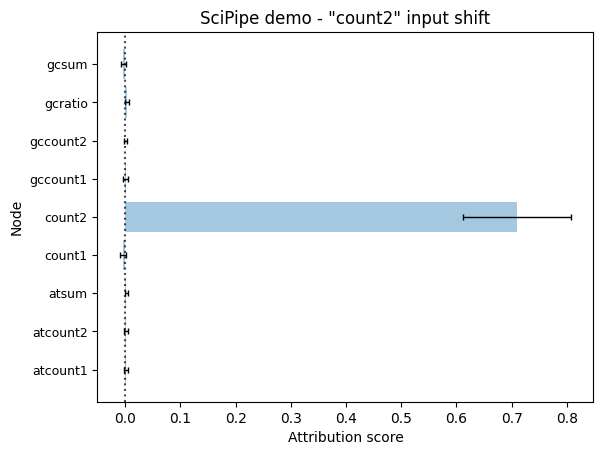

In [16]:
import math
records_count = break_count2_attr_df.shape[0]
records_means = break_count2_attr_df.mean(axis=0).to_list()
std = break_count2_attr_df.std(axis=0).to_list()
columns = break_count2_attr_df.columns.to_list()

ci95_lower = []
ci95_range = []
for m, s in zip(records_means, std):
    lower = m - 1.96*s/math.sqrt(records_count)
    ci95_lower.append(lower)
    ci95_range.append(m - lower)


import matplotlib.pyplot as plt

plt.barh(range(len(records_means)), records_means, xerr=ci95_range, alpha=0.4, align='center', error_kw={'capsize':2, 'elinewidth':1})
plt.yticks(range(len(records_means)), columns)
# plt.xscale('log')
plt.xlabel('Attribution score')
plt.ylabel('Node')
plt.yticks(fontsize=9)
# plt.xscale('symlog', base=10)
# plt.xticks([0, 0.1])
plt.axvline(0, color='black', alpha=0.7, linestyle='dotted')
plt.title('SciPipe demo - "count2" input shift')

plt.savefig("scipipe-count2.pdf", bbox_inches='tight')
plt.show()